In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
%matplotlib inline

## 简单神经网络例子
### 模拟数据并给定初始参数

In [3]:
batch_n = 100#一个批次输入数据的数量
hidden_layer = 100
input_data = 1000#每个数据的特征为1000
output_data = 10

In [4]:
x = torch.randn(batch_n,input_data)#X=100（样本数）·1000（输入特征数）
y = torch.randn(batch_n,output_data)#Y=100（样本数）·10（输出特征数）
w1 = torch.randn(input_data,hidden_layer)#W1=1000（因素特征数）·100（隐藏层特征数）
w2 = torch.randn(hidden_layer,output_data)#W2=100（隐藏层特征数）·10（输出特征数）

In [5]:
epoch_n = 20#学习次数
lr = 1e-6#学习效率

### 学习流程
#### 预测Y

$H_{1} = clamp(XW_{1})$（clamp为去掉负数，最小为0）（隐藏层特征）

$Y_{pred}=H_{1}W_{2}$（输出层特征）

#### 评估

$loss=\sum_{n=1}^{100}\sum_{i=1}^{10} (y_{pred}-y)^2 $（损失函数）

#### 学习回推

$gradY_{pred}=2(Y-Y_{pred})即(\Delta Y)$

$gradW_{2}=H_{1}^TgradY_{pred}即由gradY_{pred}=H_{1}gradW_{2}算出gradW_{2}(\Delta W_{2})$

$gradH_{1}=gradY_{pred}W_{2}^T既由gradY_{pred}=gradH_{1}W_{2}算出gradH_{1}(\Delta H_{1})$

$gradW_{1}=X^TgradH_{1}即由gradH_{1}=XgradW_{1}算出gradW_{1}(\Delta W_{1})$

更新参数：$W_{1}=W_{1}-\alpha\Delta W_{1},W_{2}=W_{2}-\alpha\Delta W_{2}$

In [6]:
for epoch in range(epoch_n):
    h1=x.mm(w1)#(100,1000)*(1000,100)-->100*100
    print(h1.shape)
    h1=h1.clamp(min=0)
    y_pred = h1.mm(w2)
    
    loss = (y_pred-y).pow(2).sum()
    print("epoch:{},loss:{:.4f}".format(epoch,loss))
    
    grad_y_pred = 2*(y_pred-y)
    grad_w2 = h1.t().mm(grad_y_pred)
    
    grad_h = grad_y_pred.clone()
    grad_h = grad_h.mm(w2.t())
    grad_h.clamp_(min=0)#将小于0的值全部赋值为0，相当于sigmoid
    grad_w1 = x.t().mm(grad_h)
    
    w1 = w1 -lr*grad_w1
    w2 = w2 -lr*grad_w2

torch.Size([100, 100])
epoch:0,loss:40630492.0000
torch.Size([100, 100])
epoch:1,loss:66367148.0000
torch.Size([100, 100])
epoch:2,loss:199418912.0000
torch.Size([100, 100])
epoch:3,loss:463755552.0000
torch.Size([100, 100])
epoch:4,loss:238250192.0000
torch.Size([100, 100])
epoch:5,loss:3862877.0000
torch.Size([100, 100])
epoch:6,loss:2828448.0000
torch.Size([100, 100])
epoch:7,loss:2365580.7500
torch.Size([100, 100])
epoch:8,loss:2089149.0000
torch.Size([100, 100])
epoch:9,loss:1885532.1250
torch.Size([100, 100])
epoch:10,loss:1718925.0000
torch.Size([100, 100])
epoch:11,loss:1576648.2500
torch.Size([100, 100])
epoch:12,loss:1453304.5000
torch.Size([100, 100])
epoch:13,loss:1344403.5000
torch.Size([100, 100])
epoch:14,loss:1247530.8750
torch.Size([100, 100])
epoch:15,loss:1160873.1250
torch.Size([100, 100])
epoch:16,loss:1083018.0000
torch.Size([100, 100])
epoch:17,loss:1013092.4375
torch.Size([100, 100])
epoch:18,loss:950236.7500
torch.Size([100, 100])
epoch:19,loss:893275.0000


## MNIST数据集进行神经网络的机器学习
### 一、MNIST数据集
#### 下载MNIST数据集

In [7]:
from torchvision.datasets import MNIST
mnist_train = MNIST(root="/MNIST_data", train=True, download=True, transform=None)
#root表示下载路径，训练模式取训练集，是否下载：是

#### 展示图片

In [8]:
import matplotlib.pyplot as plt#安装matlab库并导入matplotlib.pyplot

In [9]:
print(len(mnist_train))#len表示求它的长度，训练集有10000张
print(mnist_train[0])#返回结果有两部分，一部分是PIL图像，另一部分是图片的标签标签为5，就表示这个数字是5

60000
(<PIL.Image.Image image mode=L size=28x28 at 0x16B35D86550>, 5)


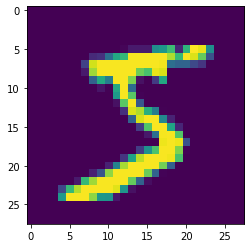

5


In [10]:
image = mnist_train[0][0]#取出具体的一张图片
plt.imshow(image)
plt.show()#把图片展示出来
print(mnist_train[0][1])#把图片的标签打印出来

### 二、数据加载

In [11]:
from torch.utils.data import DataLoader#导入数据加载器
dataloader = DataLoader(mnist_train, batch_size=1, shuffle=True)#实例化一个类，传入把训练集，batch_size设为2，shuffle设为true打乱
print(dataloader)#打印一下

### 三、transforms图像处理
图像在PIL中不是张量tensor，需要进行转换，并且转换后的格式顺序与cuda、cudnn的函数中默认的格式顺序不一样，需要经过转换才能输出图片或者处理图片

In [12]:
from torchvision import transforms#导入transforms方法
mnist_train = MNIST(root="/MNIST_data", train=True, download=True, transform=transforms.ToTensor())
#将MNIST数据集中transform改为transforms.ToTensor()
dataloader = DataLoader(mnist_train, batch_size=1, shuffle=True)#此时，将PIL图像转换成了张量形式
for (images, labels) in dataloader:
    print(images.shape)
    break#打印一次后退出

torch.Size([1, 1, 28, 28])


这里第一个“1”表1 batch_size,即一次加载一张图片
第二个“1”表示通道数，后边两个“28”分别表示图片的高和宽

In [13]:
#使用make_grid方法将两张图片融合
from torchvision.utils import make_grid##即使一张图片我们也要将它融合一下，使用make_grid方法
my_transforms = transforms.Compose([transforms.PILToTensor()])
#将多个transforms组合在一起，还可以加入标准化等图像处理
mnist_train = MNIST(root="/MNIST_data", train=True, download=True, transform=transforms.ToTensor())
dataloader = DataLoader(mnist_train, batch_size=1, shuffle=True)
for (images, labels) in dataloader:
    print(make_grid(images).shape)
    break#打印一次后退出

torch.Size([3, 28, 28])


## 全连接层

### 1.载入数据集并定义加载器

In [48]:
transformation = transforms.Compose([
    transforms.ToTensor(),       ## 转化为一个tensor， 转换到0-1之间, 将channnel放在第一维
])
train_ds = torchvision.datasets.MNIST(root="dataset", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_ds = torchvision.datasets.MNIST(root="dataset", train=False, transform=torchvision.transforms.ToTensor(), download=True)
train_dl = DataLoader(train_ds, batch_size = 64, shuffle = True)
test_dl = DataLoader(test_ds, batch_size = 256)

### 2.定义模型

In [49]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv_module = nn.Sequential(
        nn.Linear(1*28*28, 183),
        nn.ReLU(),
        nn.Linear(183,43),
        nn.ReLU(),
        nn.Linear(43,10)
        )
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.conv_module(x)
        return x

### 3.定义损失函数

In [50]:
loss_func = torch.nn.CrossEntropyLoss()
loss_func = loss_func.cuda()

### 4.定义优化模型过程

In [51]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    for x, y in trainloader:
        x = x.cuda()
        y = y.cuda()
        y_pred = model(x)
        loss = loss_func(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim = 1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
    epoch_acc = correct / total
    epoch_loss = running_loss / len(trainloader.dataset)
    
    test_correct = 0
    test_total = 0
    test_running_loss = 0
    
    with torch.no_grad():
        for x, y in testloader:
            x = x.cuda()
            y = y.cuda()
            y_pred = model(x)
            loss = loss_func(y_pred, y)
            y_pred = torch.argmax(y_pred, dim = 1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    epoch_test_acc = test_correct / test_total
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    
    print('epoch: ', epoch, 
          'loss: ', round(epoch_loss, 3),
          'accuracy: ', round(epoch_acc, 3),
          'test_loss: ', round(epoch_test_loss, 3),
          'test_accuracy: ', round(epoch_test_acc, 3))
    
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

### 5.训练模型并展示预测效果

In [52]:
model = Model()
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 20
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch, model, train_dl, test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss:  0.005 accuracy:  0.907 test_loss:  0.001 test_accuracy:  0.953
epoch:  1 loss:  0.002 accuracy:  0.962 test_loss:  0.0 test_accuracy:  0.967
epoch:  2 loss:  0.001 accuracy:  0.974 test_loss:  0.0 test_accuracy:  0.974
epoch:  3 loss:  0.001 accuracy:  0.981 test_loss:  0.0 test_accuracy:  0.976
epoch:  4 loss:  0.001 accuracy:  0.984 test_loss:  0.0 test_accuracy:  0.98
epoch:  5 loss:  0.001 accuracy:  0.988 test_loss:  0.0 test_accuracy:  0.977
epoch:  6 loss:  0.001 accuracy:  0.99 test_loss:  0.0 test_accuracy:  0.977
epoch:  7 loss:  0.0 accuracy:  0.992 test_loss:  0.0 test_accuracy:  0.975
epoch:  8 loss:  0.0 accuracy:  0.993 test_loss:  0.0 test_accuracy:  0.975
epoch:  9 loss:  0.0 accuracy:  0.994 test_loss:  0.0 test_accuracy:  0.98
epoch:  10 loss:  0.0 accuracy:  0.995 test_loss:  0.0 test_accuracy:  0.981
epoch:  11 loss:  0.0 accuracy:  0.996 test_loss:  0.0 test_accuracy:  0.977
epoch:  12 loss:  0.0 accuracy:  0.996 test_loss:  0.0 test_accuracy:  0.

## CNN神经网络

In [111]:
train_data = datasets.MNIST(root = "datasets", train = True, transform = transforms.ToTensor(), download = True)
test_data = datasets.MNIST(root = "datasets", train = False, transform = transforms.ToTensor(), download = True)
train_loader= DataLoader(train_data, batch_size = 32, shuffle = True)
test_loader= DataLoader(train_data, batch_size = 256)

In [112]:
class cnn_mod(nn.Module):
    def __init__(self):
        super(cnn_mod, self).__init__()
        self.cnnmodel1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(3,2)
        )
        self.cnnmodel2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(3,2)
        )
        self.linearmodel = nn.Sequential(
            nn.Linear(288, 100),
            nn.ReLU(),
            nn.Linear(100,10)
        )
    def forward(self, x):
        x = self.cnnmodel1(x)
        x = self.cnnmodel2(x)
        x = x.view(-1, 288)
        x = self.linearmodel(x)
        return x

In [113]:
loss_func = torch.nn.CrossEntropyLoss()
loss_func = loss_func.cuda()

In [114]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    for x, y in trainloader:
        x = x.cuda()
        y = y.cuda()
        y_pred = model(x)
        loss = loss_func(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim = 1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
    epoch_acc = correct / total
    epoch_loss = running_loss / len(trainloader.dataset)
    
    test_correct = 0
    test_total = 0
    test_running_loss = 0
    
    with torch.no_grad():
        for x, y in testloader:
            x = x.cuda()
            y = y.cuda()
            y_pred = model(x)
            loss = loss_func(y_pred, y)
            y_pred = torch.argmax(y_pred, dim = 1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    epoch_test_acc = test_correct / test_total
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    
    print('epoch: ', epoch, 
          'loss: ', round(epoch_loss, 3),
          'accuracy: ', round(epoch_acc, 3),
          'test_loss: ', round(epoch_test_loss, 3),
          'test_accuracy: ', round(epoch_test_acc, 3))
    
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [117]:
model = cnn_mod()
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 20
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch, model, train_loader, test_loader)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss:  0.005 accuracy:  0.948 test_loss:  0.0 test_accuracy:  0.983
epoch:  1 loss:  0.002 accuracy:  0.983 test_loss:  0.0 test_accuracy:  0.989
epoch:  2 loss:  0.001 accuracy:  0.988 test_loss:  0.0 test_accuracy:  0.992
epoch:  3 loss:  0.001 accuracy:  0.991 test_loss:  0.0 test_accuracy:  0.991
epoch:  4 loss:  0.001 accuracy:  0.992 test_loss:  0.0 test_accuracy:  0.995
epoch:  5 loss:  0.001 accuracy:  0.994 test_loss:  0.0 test_accuracy:  0.996
epoch:  6 loss:  0.001 accuracy:  0.994 test_loss:  0.0 test_accuracy:  0.997
epoch:  7 loss:  0.001 accuracy:  0.994 test_loss:  0.0 test_accuracy:  0.994
epoch:  8 loss:  0.0 accuracy:  0.996 test_loss:  0.0 test_accuracy:  0.997
epoch:  9 loss:  0.0 accuracy:  0.996 test_loss:  0.0 test_accuracy:  0.998
epoch:  10 loss:  0.0 accuracy:  0.996 test_loss:  0.0 test_accuracy:  0.996
epoch:  11 loss:  0.0 accuracy:  0.997 test_loss:  0.0 test_accuracy:  0.997
epoch:  12 loss:  0.0 accuracy:  0.997 test_loss:  0.0 test_accuracy: 